## Step 2: Training a simple model

In [1]:
import os
import time
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

from wholeslidedata.interoperability.detectron2.iterator import WholeSlideDetectron2Iterator
from wholeslidedata.interoperability.detectron2.trainer import WholeSlideDectectron2Trainer
from wholeslidedata.interoperability.detectron2.predictor import Detectron2DetectionPredictor
from wholeslidedata.iterators import create_batch_iterator
from wholeslidedata.visualization.plotting import plot_boxes

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model

In [ ]:
print(os.getcwd())

/workspace/source


In [3]:
# go up a level
os.chdir('..')
print(os.getcwd())

/workspace


Setting up the training configuration and parameters (can also be defined in a separate yaml file).

In [4]:
# user_config = {
#     'wholeslidedata': {
#         'default': {
#             'yaml_source': "./source/configs/training_sample.yml",
#             "seed": 42,
#             "image_backend": "openslide", #was asap
#             'labels': {
#                 "ROI": 0,
#                 "lymphocytes": 1
#             },
            
#             'batch_shape': {
#                 'batch_size': 10,
#                 'spacing': 0.5,
#                 'shape': [128,128,3],
#                 'y_shape': [1000, 6],
#             },
            
#             "annotation_parser": {
#                 "sample_label_names": ['roi'],
#             },
            
#             'point_sampler_name': "RandomPointSampler",
#             'point_sampler': {
#                 "buffer": {'spacing': "${batch_shape.spacing}", 'value': -64},
#             },
            
#             'patch_label_sampler_name': 'DetectionPatchLabelSampler',
#             'patch_label_sampler': {
#                 "max_number_objects": 1000,
#                 "detection_labels": ['lymphocytes'],
                    
#             },
            
#         }
#     }
# }

In [6]:
#NOTE: forum proposed config for the two classes ann

user_config = {
    'wholeslidedata': {
        'default': {
            'yaml_source': "./source/configs/training_full.yml",
            "seed": 42,
            "image_backend": "openslide", #was asap
            'labels': {
                "ROI": 0,
                "lymphocytes": 1,
                "monocytes": 2
            },

            'batch_shape': {
                'batch_size': 10,
                'spacing': 0.5,
                'shape': [128, 128, 3],
                'y_shape': [1000, 6],
            },

            "annotation_parser": {
                "sample_label_names": ['roi'],
            },

            'point_sampler_name': "RandomPointSampler",
            'point_sampler': {
                "buffer": {'spacing': "${batch_shape.spacing}", 'value': -64},
            },

            'patch_label_sampler_name': 'DetectionPatchLabelSampler',
            'patch_label_sampler': {
                "max_number_objects": 1000,
                "detection_labels": ['lymphocytes','monocytes'],

            },

        }
    }
}

Creating the batch generator.

In [7]:
training_batch_generator = create_batch_iterator(
    user_config=user_config,
#     user_config=r'./source/configs/training_config_full_2_classes.yml', #load the config file
    mode='training',
    cpus=1,
    iterator_class=WholeSlideDetectron2Iterator, # TODO: this is what we need to change, if we don't want to use detectron2
)

Visualizing a sample batch.

In [14]:
batch_dicts = next(training_batch_generator)
import pprint as pp
pp.pprint(batch_dicts[2])

{'image': tensor([[[108., 105., 105.,  ..., 161., 161., 155.],
         [130., 120., 118.,  ..., 160., 155., 149.],
         [158., 140., 126.,  ..., 157., 151., 145.],
         ...,
         [178., 178., 171.,  ..., 239., 250., 230.],
         [171., 168., 155.,  ..., 232., 244., 224.],
         [172., 173., 156.,  ..., 200., 217., 204.]],

        [[ 37.,  32.,  42.,  ...,  85.,  81.,  78.],
         [ 54.,  44.,  51.,  ...,  81.,  74.,  71.],
         [ 78.,  60.,  56.,  ...,  78.,  70.,  69.],
         ...,
         [131., 126., 114.,  ..., 218., 224., 200.],
         [120., 113.,  97.,  ..., 203., 212., 189.],
         [117., 115.,  94.,  ..., 166., 181., 166.]],

        [[ 90.,  91.,  97.,  ..., 139., 139., 135.],
         [110., 103., 108.,  ..., 136., 132., 128.],
         [136., 120., 113.,  ..., 133., 128., 123.],
         ...,
         [170., 167., 156.,  ..., 244., 250., 225.],
         [162., 156., 142.,  ..., 237., 245., 220.],
         [161., 160., 142.,  ..., 204., 217

In [ ]:
# for _ in range(10):
#     batch_dicts = next(training_batch_generator)
#     fig, ax = plt.subplots(1,8, figsize=(20,10))
#     for i in range(8):
#         patch = batch_dicts[i]['image'].cpu().detach().numpy().transpose(1,2,0).astype('uint8')
#         _boxes =  batch_dicts[i]['instances'].gt_boxes.tensor.cpu().detach().numpy()
#         boxes = np.ones((len(_boxes), 6))
#         boxes[..., :4] = _boxes
#         max_width, max_height = batch_dicts[i]['instances'].image_size
#         ax[i].imshow(patch)
#         plot_boxes(boxes, max_width=max_width, max_height=max_height, axes=ax[i])
#     plt.show()

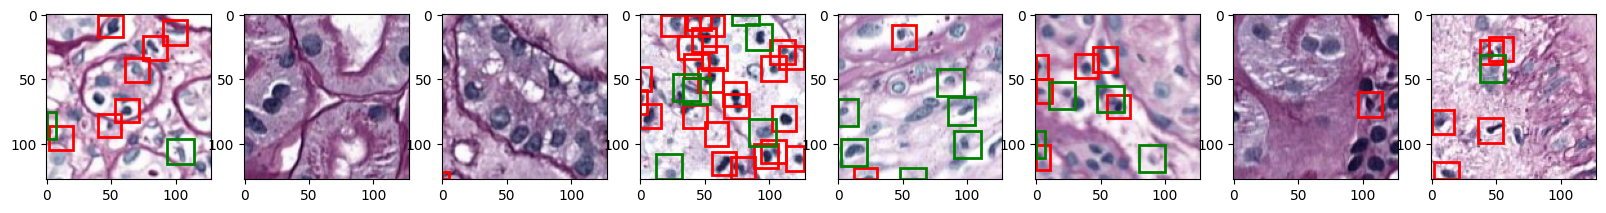

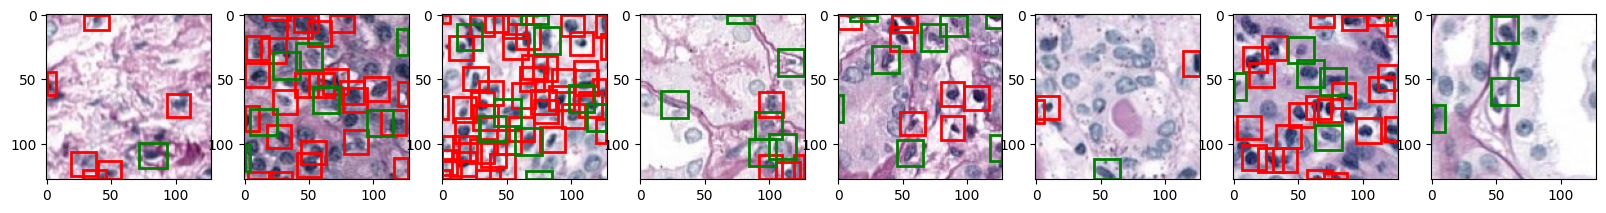

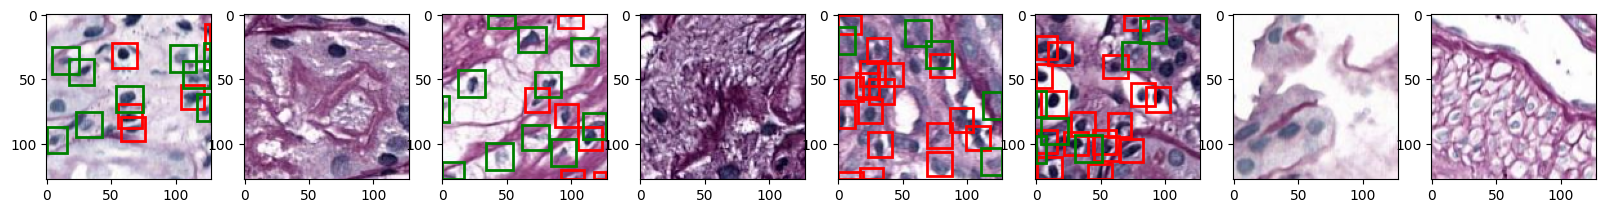

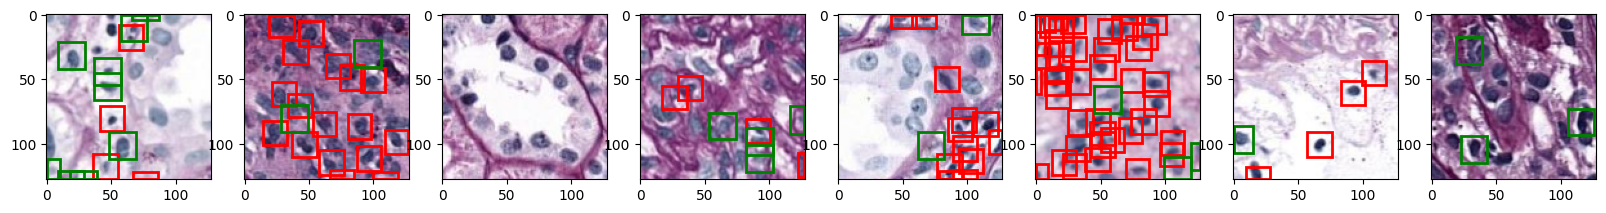

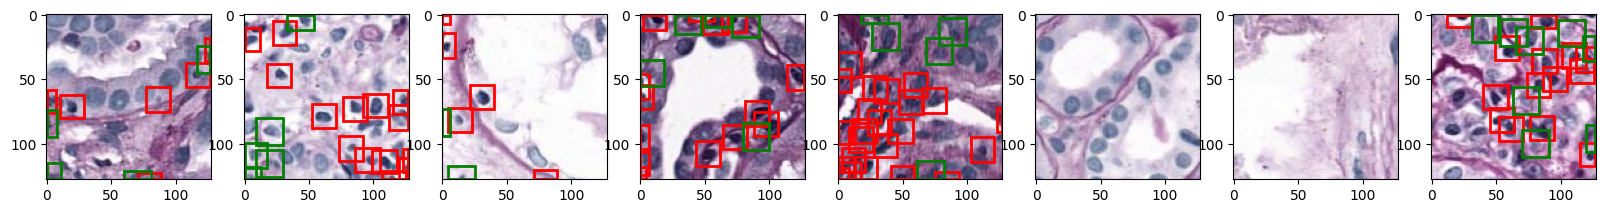

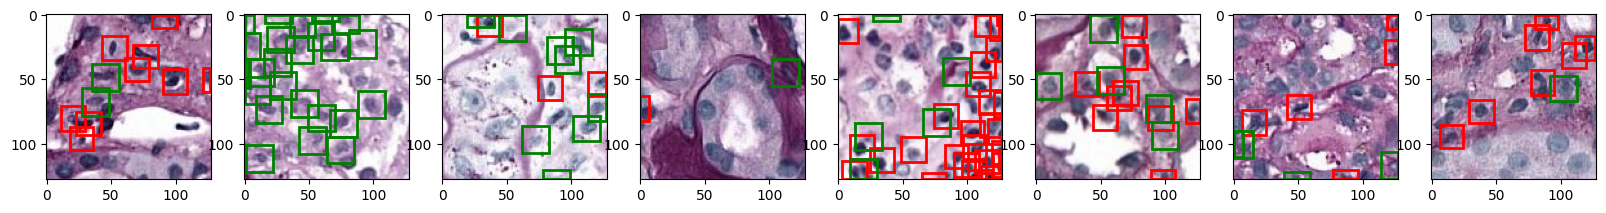

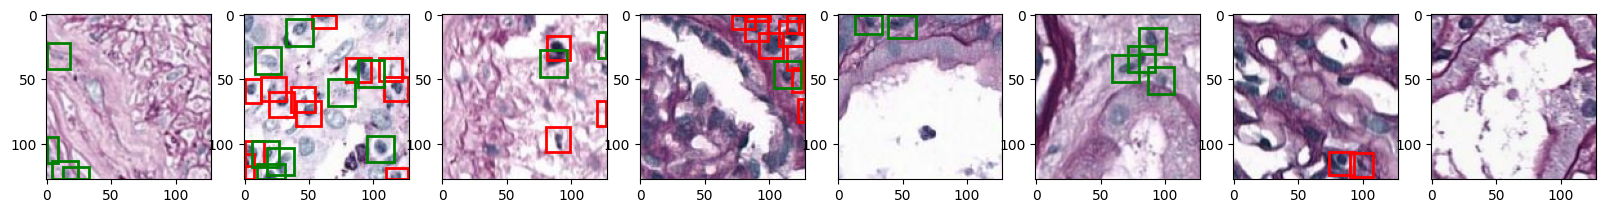

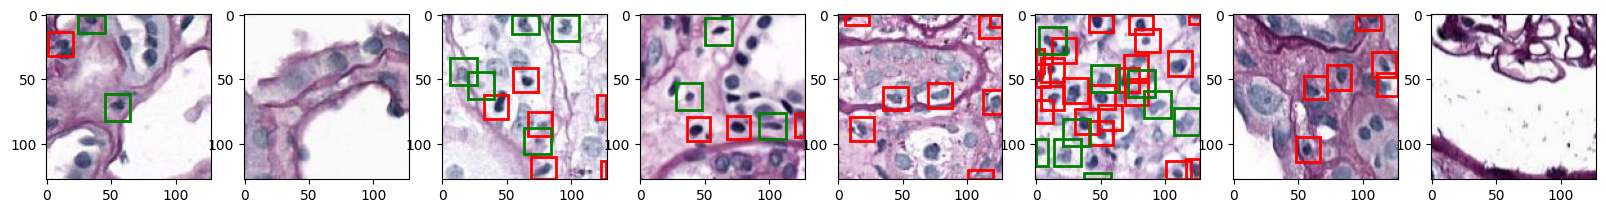

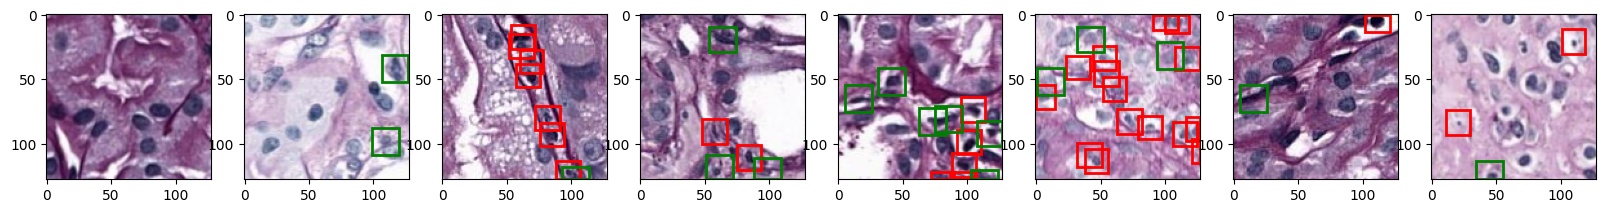

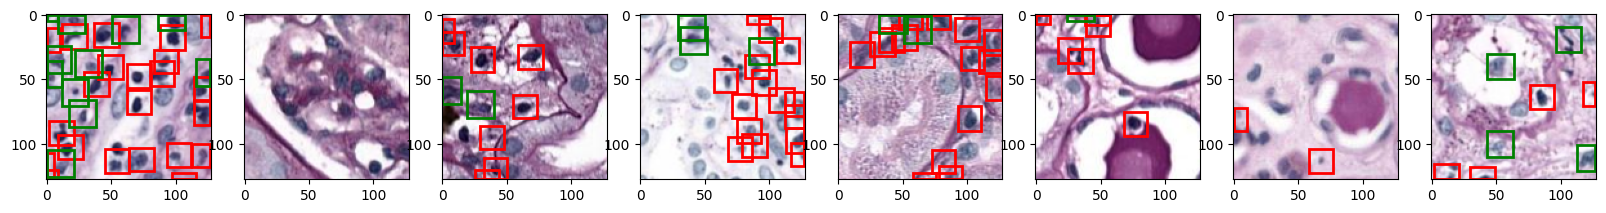

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as pltpatches
import numpy as np
from matplotlib.colors import ListedColormap

# Create a colormap that maps index 0 -> red, index 1 -> green
color_map = ListedColormap(['red', 'green'])

def plot_boxes(boxes, max_width, max_height, axes=None, output_shape=None, color_map=None):
    if axes is None:
        _, ax = plt.subplots(1, 1)
    else:
        ax = axes

    # If no color_map provided, use 'tab10' by default
    if color_map is None:
        color_map = plt.cm.get_cmap('tab10')

    for box in boxes:
        x1, y1, x2, y2, label_value, confidence = box
        label_value = int(label_value)  # Ensure label is an int for indexing colormap
        color = color_map(label_value % color_map.N)

        # Plot the box if coordinates are valid
        if (x1, y1, x2, y2) != (0, 0, 0, 0):
            rect = pltpatches.Rectangle(
                (x1, y1),
                min(max_width, max(0, x2 - x1)),
                min(max_height, max(0, y2 - y1)),
                linewidth=2,
                edgecolor=color,
                facecolor='none',
            )
            ax.add_patch(rect)

            # Optional: add label text
            # ax.text(
            #     x1, y1 - 3, f'Class: {label_value}',
            #     color=color,
            #     fontsize=10,
            #     fontweight='bold',
            #     va='bottom', ha='left',
            #     bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
            # )

    if axes is None:
        plt.show()

# Example usage with batch_dicts:
for _ in range(10):
    batch_dicts = next(training_batch_generator)
    fig, ax = plt.subplots(1, 8, figsize=(20, 10))
    for i in range(8):
        # Convert PyTorch tensor image to NumPy
        patch = batch_dicts[i]['image'].cpu().detach().numpy().transpose(1, 2, 0).astype('uint8')
        
        # Extract boxes and classes
        _boxes = batch_dicts[i]['instances'].gt_boxes.tensor.cpu().detach().numpy()
        gt_classes = batch_dicts[i]['instances'].gt_classes.cpu().detach().numpy()

        # Construct the boxes array with label and dummy confidence
        boxes = np.zeros((len(_boxes), 6))
        boxes[:, :4] = _boxes
        boxes[:, 4] = gt_classes
        boxes[:, 5] = 1.0  # dummy confidence

        max_width, max_height = batch_dicts[i]['instances'].image_size
        ax[i].imshow(patch)
        # Pass a colormap object, not a string
        plot_boxes(boxes, max_width=max_width, max_height=max_height, axes=ax[i], color_map=color_map)
    plt.show()


Creating the output folder for saving the model and results.

In [21]:
output_folder = Path('./outputs')
if not(os.path.isdir(output_folder)): os.mkdir (output_folder) 
cpus = 4

# Train the model

In [10]:
cfg = get_cfg()
# using faster rcnn architecture
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
)


cfg.DATASETS.TRAIN = ("detection_dataset2",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 #was 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[16, 24, 32]]

cfg.SOLVER.IMS_PER_BATCH = 10
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000  # 2000 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.SOLVER.STEPS = (10, 100, 250)
cfg.SOLVER.WARMUP_ITERS = 0
cfg.SOLVER.GAMMA = 0.5

cfg.OUTPUT_DIR = str(output_folder)
output_folder.mkdir(parents=True, exist_ok=True)


model = build_model(cfg)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Parameter Count:\n" + str(pytorch_total_params))

trainer = WholeSlideDectectron2Trainer(cfg, user_config=user_config, cpus=cpus)
trainer.resume_or_load(resume=False)
trainer.train()

Parameter Count:
103962163
[12/03 16:55:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
 

X-101-32x8d.pkl: 356MB [00:26, 13.6MB/s]                               


[12/03 16:56:12 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[12/03 16:56:12 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint                         | Shapes                                          |
|:------------------|:--------------------------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_b,bn_rm,bn_riv,bn_s,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.conv2.*    | res2_0_branch2b_{bn_b,bn_rm,bn_riv,bn_s,w}  | (256,) (256,) (256,) (256,) (256,8,3,3)         |
| res2.0.conv3.*    | res2_0_branch2c_{bn_b,bn_rm,bn_riv,bn_s,w}  | (256,) (256,) (256,) (256,) (256,256,1,1)       |
| res2.0.shortcut.* | res2_0_branch1_{bn_b,bn_rm,bn_riv,bn_s,w}   | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_b,bn_rm,bn_riv,bn_s,w}  | (256,) (256,) (256,) (256,) (256,2

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  linear.{bias, weight}


[12/03 16:56:13 d2.engine.train_loop]: Starting training from iteration 0


/venv/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/venv/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/03 16:56:33 d2.utils.events]:  eta: 0:16:11  iter: 19  total_loss: 1.035  loss_cls: 0.2305  loss_box_reg: 0.164  loss_rpn_cls: 0.5782  loss_rpn_loc: 0.02697  time: 0.9942  data_time: 0.0046  lr: 0.0005  max_mem: 3345M
[12/03 16:56:54 d2.utils.events]:  eta: 0:16:01  iter: 39  total_loss: 0.6042  loss_cls: 0.1546  loss_box_reg: 0.1336  loss_rpn_cls: 0.2702  loss_rpn_loc: 0.02619  time: 1.0149  data_time: 0.0044  lr: 0.0005  max_mem: 3345M
[12/03 16:57:15 d2.utils.events]:  eta: 0:15:47  iter: 59  total_loss: 0.4977  loss_cls: 0.1666  loss_box_reg: 0.156  loss_rpn_cls: 0.1333  loss_rpn_loc: 0.02766  time: 1.0178  data_time: 0.0039  lr: 0.0005  max_mem: 3345M
[12/03 16:57:35 d2.utils.events]:  eta: 0:15:21  iter: 79  total_loss: 0.4954  loss_cls: 0.1698  loss_box_reg: 0.1728  loss_rpn_cls: 0.1221  loss_rpn_loc: 0.02098  time: 1.0137  data_time: 0.0039  lr: 0.0005  max_mem: 3345M
[12/03 16:57:56 d2.utils.events]:  eta: 0:15:07  iter: 99  total_loss: 0.5252  loss_cls: 0.1654  loss_box_r

Evaluation.

In [11]:
cfg = get_cfg()

cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
)


cfg.DATASETS.TRAIN = ("detection_dataset2",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[16, 24, 32]]

cfg.SOLVER.IMS_PER_BATCH = 10
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 300 #was 2000  # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.SOLVER.WARMUP_ITERS = 0
cfg.SOLVER.GAMMA = 0.5

cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.1

cfg.OUTPUT_DIR = str(output_folder)
output_folder.mkdir(parents=True, exist_ok=True)

cfg.MODEL.WEIGHTS = os.path.join(output_folder, "model_final.pth")

model = build_model(cfg)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Parameter Count:\n" + str(pytorch_total_params))

Parameter Count:
103962163


In [13]:
predictor = Detectron2DetectionPredictor(cfg)
with create_batch_iterator(
    user_config=user_config,
    mode='training',
    cpus=4,
) as training_batch_generator:
    for _ in range(5):
        fig, ax = plt.subplots(1,5, figsize=(20,10))
        batch_x, batch_y, info = next(training_batch_generator)
        predicted_batch = predictor.predict_on_batch(batch_x)
        for i in range(5):
            patch = batch_x[i]
            boxes =  predicted_batch[i]['boxes']
            confidences = predicted_batch[i]['confidences']
            filtered_boxes = []
            for box, confidence in zip(boxes, confidences):
                if confidence > 0.3:
                    filtered_boxes.append(box)
            ax[i].imshow(patch)
            plot_boxes(filtered_boxes, max_width=64, max_height=64, axes=ax[i])
        plt.show()

OSError: [Errno 28] No space left on device